# Preliminaries

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
pip install --upgrade scipy

     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import statsmodels.formula.api as smf
import seaborn as sns

data=pd.read_csv("/content/drive/My Drive/20200907_FOX_ridehailingdata_012020.csv")

In [ ]:
data.head

<bound method NDFrame.head of       merchant_name  total_paid  ...  arrival_address_longitude product_class
0                g7       44.70  ...                       2.31            g7
1                g7       29.10  ...                        NaN     g7connect
2                g7       79.90  ...                       2.27            g7
3                g7        9.10  ...                        NaN            g7
4                g7       53.60  ...                        NaN            g7
...             ...         ...  ...                        ...           ...
31810        kapten       15.15  ...                       2.34           NaN
31811        kapten       23.85  ...                       2.29           NaN
31812        kapten        9.40  ...                       2.40           NaN
31813        kapten       24.30  ...                       2.37           NaN
31814        kapten       45.70  ...                       2.30           NaN

[31815 rows x 16 columns]>

In [ ]:
data.dtypes

merchant_name                   object
total_paid                     float64
promo                          float64
duration                        object
distance                       float64
email_date                      object
email_time                      object
departure_date                  object
departure_time                  object
arrival_date                    object
arrival_time                    object
departure_address_latitude     float64
departure_address_longitude    float64
arrival_address_latitude       float64
arrival_address_longitude      float64
product_class                   object
dtype: object

# Question 1

In [ ]:
data.describe()

,total_paid,promo,distance,departure_address_latitude,departure_address_longitude,arrival_address_latitude,arrival_address_longitude
count,31815.000000,31815.000000,27644.000000,31341.000000,31341.000000,31189.000000,31189.000000
mean,18.988601,0.483133,7.170960,48.342012,2.508062,48.353069,2.500512
std,14.185427,1.987083,7.647575,1.546082,1.401932,1.535332,1.450660
min,0.000000,0.000000,0.000000,38.690000,-9.440000,38.650000,-9.380000
25%,9.710000,0.000000,2.570000,48.820000,2.290000,48.820000,2.290000
50%,15.000000,0.000000,5.070000,48.850000,2.340000,48.850000,2.340000
75%,23.940000,0.000000,8.990000,48.880000,2.380000,48.880000,2.390000
max,219.800000,81.100000,143.030000,54.770000,25.270000,54.680000,25.280000


# Question 2

In [ ]:
data.isnull().sum()

merchant_name                      0
total_paid                         0
promo                              0
duration                        8362
distance                        4171
email_date                         0
email_time                         0
departure_date                 27396
departure_time                  1516
arrival_date                   30731
arrival_time                    1162
departure_address_latitude       474
departure_address_longitude      474
arrival_address_latitude         626
arrival_address_longitude        626
product_class                   8594
dtype: int64

Missing data could skew the distribution and create biased estimators for values. This is because we have a smaller sample to analyse and therefore can be less certain about the results of future analyses. This would be especially significant if certain values are missing specifically based for single merchants, as they could't be compared to the others.  

# Question 3

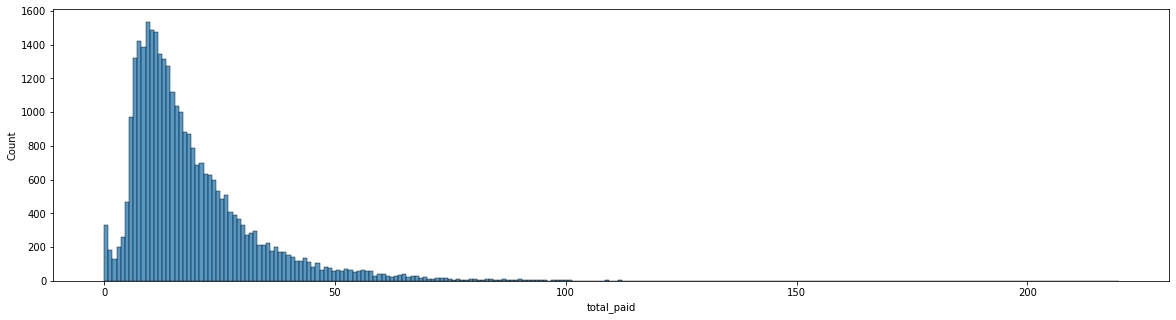

In [ ]:
plt.subplots(figsize=(20,5)) 
sns.histplot(data["total_paid"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


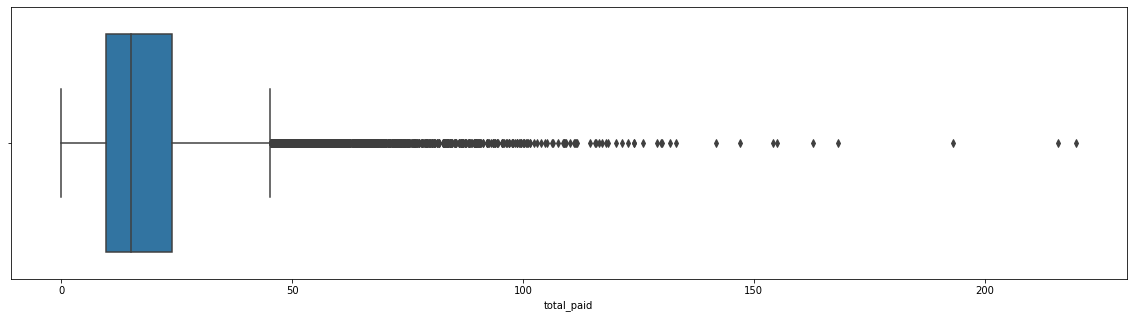

In [ ]:
plt.subplots(figsize=(20,5))
sns.boxplot(data["total_paid"])

The histogram and boxplot show that the majority of the "total_paid" values are between 0 and 50. We can see this from the right-skewed histogram and from the IQR of the box-plot, which indicates 50% of the values. From this information we can understand that consumers tend to use ride hailing services as a low-cost option to move between locations. There also seems to be a significant number of outliers for prices above c. 45€.

# Question 4

In [ ]:
deciles = pd.qcut(data["total_paid"], 10)
crosstab = pd.crosstab(data["merchant_name"], deciles)
crosstab

total_paid,"(-0.001, 6.74]","(6.74, 8.75]","(8.75, 10.68]","(10.68, 12.696]","(12.696, 15.0]","(15.0, 17.88]","(17.88, 21.64]","(21.64, 26.7]","(26.7, 36.176]","(36.176, 219.8]"
merchant_name,,,,,,,,,,
bolt,135,206,179,195,203,148,143,123,135,99
g7,1,12,28,52,78,126,207,233,294,481
heetch,102,198,135,145,162,140,155,173,156,112
kapten,501,533,479,530,537,531,591,574,527,498
lecab,0,0,0,2,1,0,4,6,6,19
marcel,29,9,7,20,21,10,16,24,26,34
uber,2423,2223,2356,2226,2192,2221,2063,2048,2033,1939


From the data we can obserce that uber is the most used ride hailing service followed by kapten. The merchants have a relatively stable distribution of values spread across different price points. Exceptions for this are g7 and lecab, where the service seems to be used for higher price journeys. Uber and Bolt on the other hand seems to have a slightly negative correlation between price paid and number of rides. 

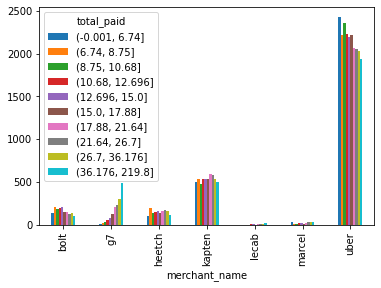

In [ ]:
crosstab.plot(kind="bar")

# Question 5

In [ ]:
from geopy import distance

def compute_distance(dep_lon, dep_lat, arr_lon, arr_lat):
    if np.isnan(np.sum([dep_lon, dep_lat, arr_lon, arr_lat])):
        return np.nan
    else:
        return distance.vincenty((dep_lat, dep_lon), (arr_lat, arr_lon)).km

def compute_distance_pandas(row):
    return compute_distance(
        row["departure_address_longitude"],
        row["departure_address_latitude"],
        row["arrival_address_longitude"],
        row["arrival_address_latitude"],
    )

data["distance2"] = data.apply(compute_distance_pandas, axis=1)

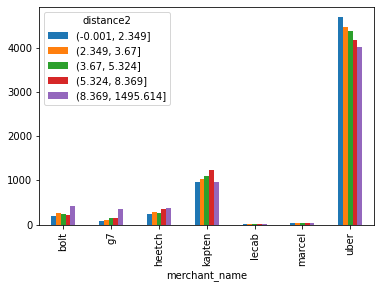

In [ ]:
deciles = pd.qcut(data["distance2"], 5)
crosstab = pd.crosstab(data["merchant_name"], deciles)
crosstab.plot(kind="bar")

Bolt, g7, and heetch all seem to have an increasing number of clients as the distance travelled increases. Kapten has the same trend, which breaks down for the highest class of distance travelled. This means that these services tend to be preferred by consumers for longer rides. In comparison we see the opposite with uber. There is a decreasing number of rides as the distance travelled increases, which indicates that uber seems to be preferred for shorter trips.  

# Question 6

In [ ]:
def compute_duration(dep_time, arr_time):
    if pd.isnull(dep_time) or pd.isnull(arr_time):
        return np.nan
    else:
        return (
            pd.to_datetime(arr_time) - pd.to_datetime(dep_time)
        ).seconds / 60

def compute_duration_pandas(row):
    return compute_duration(row["departure_time"], row["arrival_time"])

data["duration2"] = data.apply(compute_duration_pandas, axis=1)

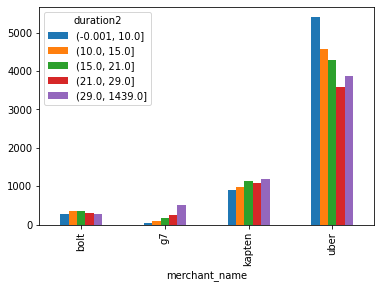

In [ ]:
deciles = pd.qcut(data["duration2"], 5)
crosstab = pd.crosstab(data["merchant_name"], deciles)
crosstab.plot(kind="bar")

bolt seems to have an equal amount of riders for each trip duration, whereas g7 and kapten seem to have an increasing number of trips as the duration increases. This indicates that g7 and kapten are the preferred choice for rides with a longer duration. Uber has the opposite trend, where they have a larger number of rides as the duration of the ride is lower. This indicates that uber is preferred for shorter rides. 

# Question 7

In [ ]:
def exec_for_each_merchant(data, func):
    for merchant in data["merchant_name"].unique():
        print(f"Running for merchant {merchant}")
        merchant_data = data[data["merchant_name"] == merchant]
        func(merchant_data)
        print()

Running for merchant g7
No data to plot for variable distance.


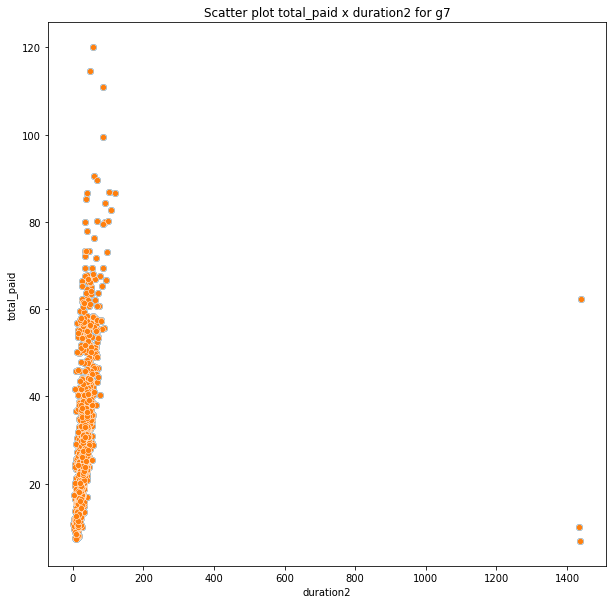


Running for merchant uber


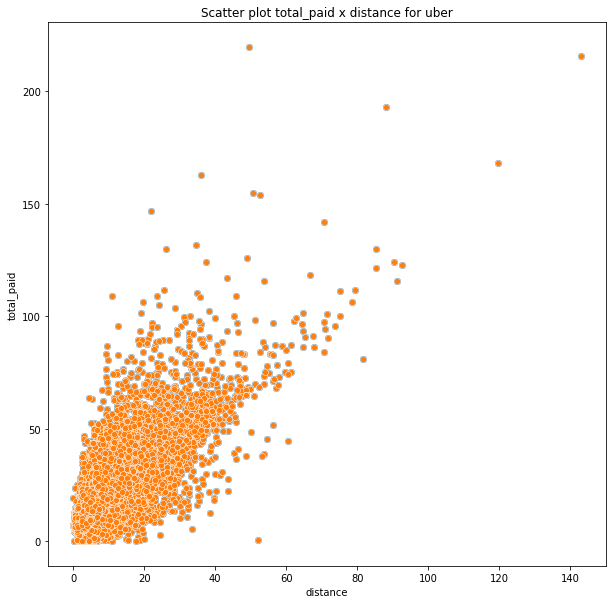

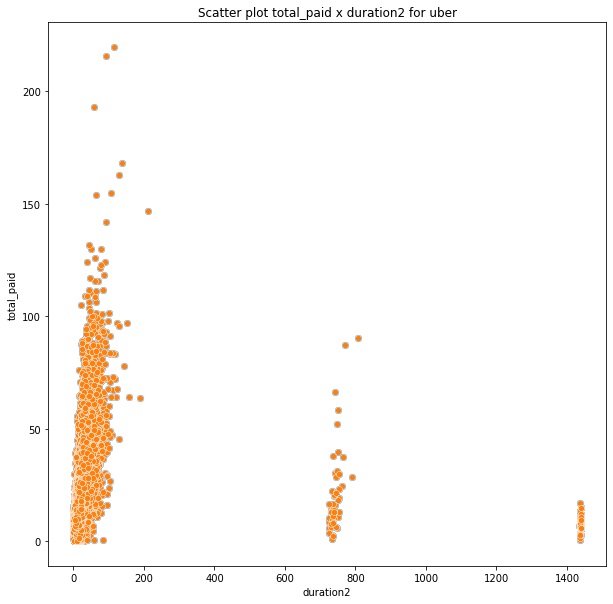


Running for merchant lecab
No data to plot for variable distance.
No data to plot for variable duration2.

Running for merchant heetch
No data to plot for variable distance.
No data to plot for variable duration2.

Running for merchant marcel
No data to plot for variable distance.
No data to plot for variable duration2.

Running for merchant bolt


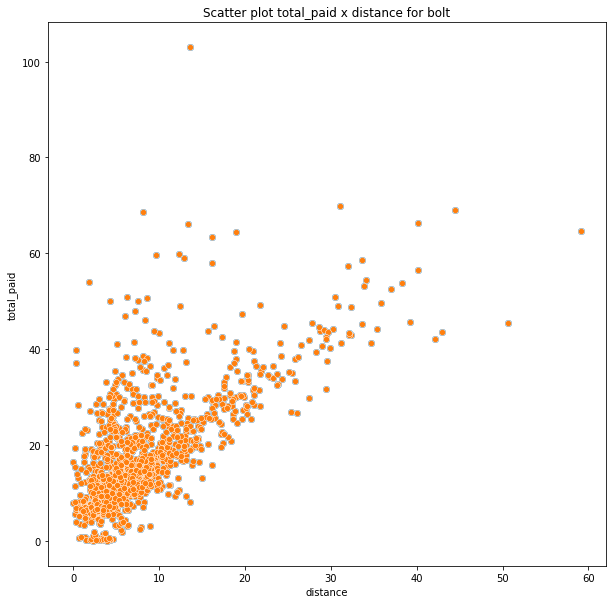

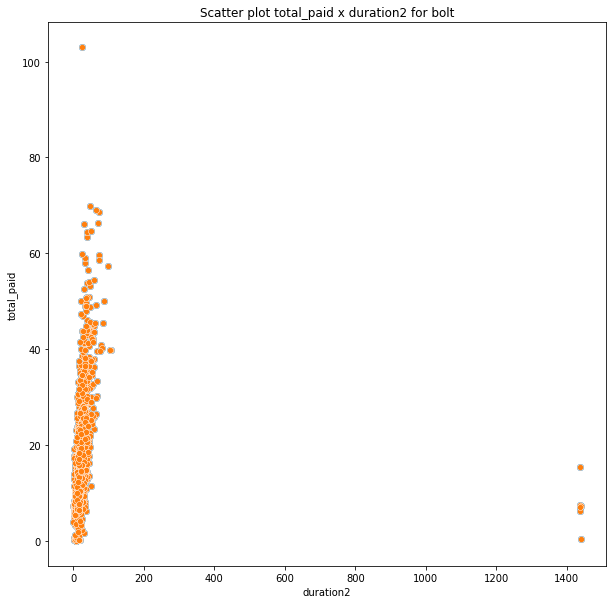


Running for merchant kapten


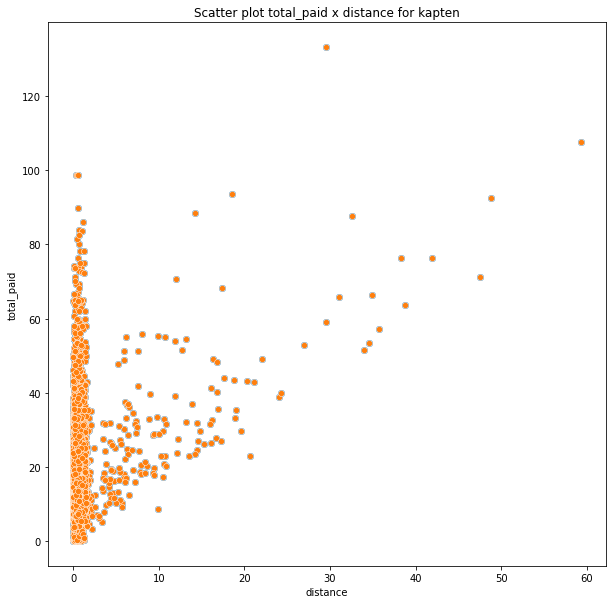

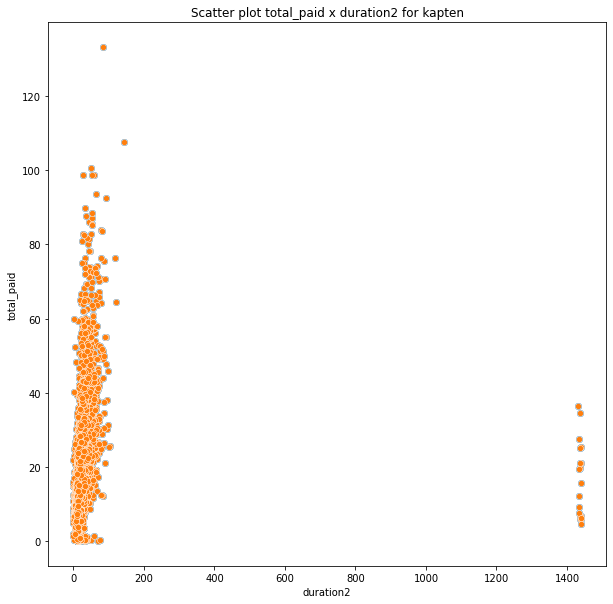

In [ ]:
def scatter(data, var1, var2):
    if len(data[data[var2].notnull()]) == 0:
        print(f"No data to plot for variable {var2}.")
        return

    plt.figure(figsize=(10,10))
    plt.scatter(y=data[var1], x=data[var2])
    sns.scatterplot(data=data, x=var2, y=var1)
    name = data['merchant_name'].unique()[0]
    plt.title(f"Scatter plot {var1} x {var2} for {name}")
    plt.show()

def plots(merchant_data):
    scatter(merchant_data, "total_paid", "distance")
    scatter(merchant_data, "total_paid", "duration2")

exec_for_each_merchant(data, plots)

# Question 8

In [ ]:
def Info(x):
    print(f"{'Average:':<20} {x.mean():<5}")
    print(f"{'Median:':<20} {x.median():<5}")
    print(f"{'Standard deviation:':<20} {x.std():<5}")
    print(f"{'Min:':<20} {x.min():<5}")
    print(f"{'Max:':<20} {x.max():<5}")

data2 = data[data["merchant_name"].isin(["g7", "uber", "kapten"])]

def infos(merchant_data):
    for variable in ["total_paid", "distance", "duration2"]:
        print(f"Variable {variable}:")
        Info(merchant_data[variable])
        print()

exec_for_each_merchant(data2, infos)

Running for merchant g7
Variable total_paid:
Average:             31.975383597883624
Median:              27.1 
Standard deviation:  17.38444357302877
Min:                 6.4  
Max:                 129.0

Variable distance:
Average:             nan  
Median:              nan  
Standard deviation:  nan  
Min:                 nan  
Max:                 nan  

Variable duration2:
Average:             34.979553903345725
Median:              28.0 
Standard deviation:  75.86185455759092
Min:                 2.0  
Max:                 1439.0


Running for merchant uber
Variable total_paid:
Average:             18.277290093905293
Median:              14.33
Standard deviation:  13.97413790186191
Min:                 0.0  
Max:                 219.8

Variable distance:
Average:             8.39351040324071
Median:              5.91 
Standard deviation:  7.776436812719269
Min:                 0.02 
Max:                 143.03

Variable duration2:
Average:             29.034431964647396
Median:  

Uber and Kapten both have "total_paid" means and std_dev at c. 18 and 13 respectively. Interestingly, the distance travelled for Kapten is significantly lower than that of uber, which may indicate that the service that Kapten offers is significantly more expencive based on the distance travelled. In comparison, g7 has a "total_paid" mean of c. 31 with a much higher std_dev of 17. Since the mean duration of g7 rides is only about 15% higher we can estimate their service to be the most costly based on the duration of the ride. 

# Question 9

In [ ]:
def confidence_95(merchant_data):
    variable = merchant_data["total_paid"]
    print(st.t.interval(alpha=0.95, df=len(variable)-1, loc=np.mean(variable), scale=st.sem(variable)))

exec_for_each_merchant(data2, confidence_95)

Running for merchant g7
(31.09842112357683, 32.85234607219042)

Running for merchant uber
(18.09145513438603, 18.463125053424555)

Running for merchant kapten
(18.50470760223955, 19.22151763828115)



g7's customers pay a higher price compared to those of uber and kapten, which have a similar confidence interval for thr "total_paid" value. The reason for this however is unclear based soley based on this information.

# Question 10

In [ ]:
def t_test_duration(merchant_data):
    data_without_nans = merchant_data[merchant_data["duration2"].notnull()]
    t_stat, p_value = st.ttest_1samp(data_without_nans["duration2"], 20)
    print(f"T statistic: {t_stat}")
    print(f"P value: {p_value}")

exec_for_each_merchant(data2, t_test_duration)

Running for merchant g7
T statistic: 6.477114289313129
P value: 1.4199692967217648e-10

Running for merchant uber
T statistic: 12.139353393443589
P value: 8.408055068022002e-34

Running for merchant kapten
T statistic: 6.126855959808974
P value: 9.609763230967085e-10



# Question 11

In [ ]:
uberx = data[data["product_class"] == "uberx"]
pool = data[data["product_class"] == "pool"]
t_stat, p_value = st.ttest_ind(uberx["total_paid"], pool["total_paid"], equal_var=False, alternative="greater")
print(f"T statistic: {t_stat}")
print(f"P value: {p_value}")

T statistic: 16.281345907265116
P value: 2.2846747976650948e-58


Since p is less than 1%, the null hypothesis (equal means) is refuted. The alternative (uberx > pool) is then validated.

# Question 12

In [ ]:
def regression(merchant_data):
    variables = [
        variable
        for variable in ["distance", "duration2"]
        if len(merchant_data[merchant_data[variable].notnull()]) != 0
    ]

    formula = f"total_paid ~ {' + '.join(variables)}"
    print(f"Formula used: {formula}")
    results = smf.ols(formula, merchant_data).fit()
    print(results.summary(alpha=0.01))

exec_for_each_merchant(data2, regression)

Running for merchant g7
Formula used: total_paid ~ duration2
                            OLS Regression Results                            
Dep. Variable:             total_paid   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     18.29
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           2.07e-05
Time:                        11:00:46   Log-Likelihood:                -4536.9
No. Observations:                1076   AIC:                             9078.
Df Residuals:                    1074   BIC:                             9088.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.005      0.995]
----------------------------------------------------------------------

For g7 we see that the slope coefficient for duration is positive, which means that as the ride time increases so will the price. The coefficient is statistically significant. The R-Squared is very low however (close to 0), which indicates that the model is not well described by its variables. 
For Uber we have a higher R-Squared value of 0.584, which means a large part of the prediction is described within the model. The slope coefficients for duration and distance are positive which means that price increases with distance and time. Lastly, for Kapten we also see positive coefficients for distance and duration, however the low R-Squared value of 0.096 indicates that less of the price prediction is explained by these variables as compared to Uber. 

# Question 13

In [ ]:
uber_data = data[data["merchant_name"] == "uber"]

formula = f"total_paid ~ distance"
print(f"Formula used: {formula}")
results = smf.ols(formula, uber_data).fit()
print(results.summary(alpha=0.05))

Formula used: total_paid ~ distance
                            OLS Regression Results                            
Dep. Variable:             total_paid   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                 3.049e+04
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:00:53   Log-Likelihood:                -78590.
No. Observations:               21724   AIC:                         1.572e+05
Df Residuals:                   21722   BIC:                         1.572e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6

It seems that with a ride of 1km more we should expect a price difference greater than 1€ (1.37€).

# Question 14

In [ ]:
models = {
    "uber": {
        "intercept": 6.7128,
        "distance_price": 1.3726,
        "duration2_price": 0.0015
    },

    "g7": {
        "intercept": 30.1371,
        "distance_price": 0,
        "duration2_price": 0.0282
    },

    "kapten": {
        "intercept": 17.2782,
        "distance_price": 1.3601,
        "duration2_price": 0.0110
    }
}

duration = 55  # (23:25 - 22:30)
distance = 22.7

for name, model in models.items():
    print(f"Estimation for {name}")
    price = (
        model["intercept"]
        + duration * model["duration2_price"]
        + distance * model["distance_price"]
    )

    print(f"Price: {price}")
    print()


Estimation for uber
Price: 37.95332

Estimation for g7
Price: 31.6881

Estimation for kapten
Price: 48.75747



A price of 47€ seems slightly high for this specific ride when compared to the predictions. Especially, considering the ride was made with Uber and the actual price was c. 9€ higher than the prediction. While a price of 47€ seems reasonable for a ride with kapten, it seems even more overpriced when looking at the g7 estimation. 

# Question 15

A simple way to improve the prediction machine would be to have access to a larger and more complete data set, as this would allow for a more granual analysis. Using the existing data it would be useful to create a new variable to determine the relation between demand of rides and supply of drivers. This would greatly help improve the prediction model, as it would take into account the situational dynamics that could determine willingness to pay for a ride. This variable could be made by calculating the number of rides within a given time frame and perhaps by introducing the number of available drivers and submitted orders (accepted and cancelled). 

In order to imrpove the price prediction it would be helpful to incorporate external data in order to improve the understanding of the situation that customers and riders are in. A useful metric would be the weather at the time of the ride. Perhaps clients are willing to pay more on a rainy day in order to avoid walking or maybe the duration of a ride is longer during bad weather due to traffic problems. This would be a fundamental factor to assess, especially with relation to supply and demand. Another external factor to assess would be the number and reason for cancellations. This is might give insight to price prediction, as drivers might cancel rides if they find one for a higher price, or riders may cancel the order if they find a cheaper offer for the same destination on a competitors platform. The last factor that would be vital to look at is other logistical circumstances. For example, suppose the RER A is not working then it is likely to see an increase in rides and also price for destinations along this train line. Another example would be the departure or destination. If it is a train station or an airport the price might be higher. Such factors should obviously be taken into consideration when making an predictive model.

